# Climbing Route Color Filter (Single Image)

This notebook loads a single climbing wall photo, calibrates an HSV color range for a chosen route color, generates a mask with morphology cleanup, extracts components, and overlays detections. Optional: perspective correction and export.

Expected input: `../data/wall.jpg`.



In [71]:
import sys, platform
print(sys.executable)
print(platform.python_version())

/usr/local/bin/python3
3.11.9


In [72]:
# Imports
import os
import json
from typing import List, Tuple

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Optional interactive widgets (sliders, buttons)
try:
    from ipywidgets import interact, interactive_output, VBox, HBox, IntSlider, FloatSlider, Button, Output, Checkbox
    WIDGETS_OK = True
except Exception:
    WIDGETS_OK = False

print(f"OpenCV: {cv2.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Widgets available: {WIDGETS_OK}")



OpenCV: 4.12.0
NumPy: 2.3.4
Widgets available: True


DATA_PATH: /Users/newuser/Downloads/sky-take-out/climbOcr/data
IMG_PATH: /Users/newuser/Downloads/sky-take-out/climbOcr/data/wall.jpg


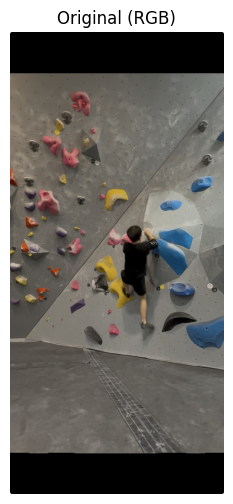

In [73]:
# Paths and image loading
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
IMG_PATH = os.path.join(DATA_PATH, "wall.jpg")
print("DATA_PATH:", DATA_PATH)
print("IMG_PATH:", IMG_PATH)

if not os.path.exists(IMG_PATH):
    print("Image not found. Please place a wall photo at:")
    print(IMG_PATH)
    display_missing = True
else:
    display_missing = False

img_bgr = None
img_rgb = None
if not display_missing:
    img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
    if img_bgr is None:
        print("Failed to read image. Check file permissions/format.")
    else:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8,6))
        plt.imshow(img_rgb)
        plt.title("Original (RGB)")
        plt.axis('off')
        plt.show()



In [74]:
# KMeans color clustering in HSV space using OpenCV

selected_cluster_idx = None
cluster_centers = None
cluster_labels = None
cluster_sizes = None

def cluster_colors_hsv(img_hsv: np.ndarray, k: int = 6, max_pixels: int = 50000, 
                       downsample_to_width: int = 640) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Cluster colors using OpenCV kmeans in HSV space."""
    if img_hsv is None:
        return None, None, None
    
    h, w = img_hsv.shape[:2]
    
    # Option 1: Downsample if too large
    if w > downsample_to_width:
        scale = downsample_to_width / w
        small_h = int(h * scale)
        img_sample = cv2.resize(img_hsv, (downsample_to_width, small_h), interpolation=cv2.INTER_AREA)
    else:
        img_sample = img_hsv.copy()
    
    # Reshape to Nx3 for kmeans
    data = img_sample.reshape(-1, 3).astype(np.float32)
    
    # Option 2: Random subsample if still too many pixels
    if len(data) > max_pixels:
        indices = np.random.choice(len(data), max_pixels, replace=False)
        data = data[indices]
    
    # OpenCV kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    attempts = 10
    flags = cv2.KMEANS_PP_CENTERS
    
    compactness, labels, centers = cv2.kmeans(data, k, None, criteria, attempts, flags)
    
    # Convert centers back to uint8 HSV
    centers_uint8 = np.uint8(centers)
    
    # Count cluster sizes (approximate since we may have subsampled)
    unique, counts = np.unique(labels, return_counts=True)
    sizes = np.zeros(k)
    for idx, cnt in zip(unique, counts):
        sizes[idx] = cnt
    
    return centers_uint8, labels, sizes

def preview_cluster_mask(img_hsv: np.ndarray, cluster_center: np.ndarray, 
                         margin_h: int = 10, margin_s: int = 40, margin_v: int = 40) -> np.ndarray:
    """Generate mask for a cluster center with margins."""
    if img_hsv is None or cluster_center is None:
        return None
    
    h, s, v = cluster_center[0], cluster_center[1], cluster_center[2]
    
    lower = np.array([max(0, h - margin_h), max(0, s - margin_s), max(0, v - margin_v)], dtype=np.uint8)
    upper = np.array([min(179, h + margin_h), min(255, s + margin_s), min(255, v + margin_v)], dtype=np.uint8)
    
    return cv2.inRange(img_hsv, lower, upper)

def hsv_to_rgb_swatch(hsv: np.ndarray) -> Tuple[int, int, int]:
    """Convert HSV (uint8) to RGB tuple for display."""
    hsv_3d = np.array([[hsv]], dtype=np.uint8)
    rgb_3d = cv2.cvtColor(hsv_3d, cv2.COLOR_HSV2RGB)
    r, g, b = rgb_3d[0, 0].tolist()
    return (int(r), int(g), int(b))



In [75]:
# Mask generation with morphology and component detection

final_mask = None
final_components = []

def generate_mask_from_selection(img_hsv: np.ndarray, 
                                  use_cluster: bool = False, cluster_idx: int = None,
                                  use_eyedropper: bool = False, 
                                  lower_hsv: np.ndarray = None, upper_hsv: np.ndarray = None) -> np.ndarray:
    """Generate mask from selected method (cluster, eyedropper, or manual bounds)."""
    if img_hsv is None:
        return None
    
    if use_cluster and cluster_idx is not None and cluster_centers is not None:
        center = cluster_centers[cluster_idx]
        mask = preview_cluster_mask(img_hsv, center)
        return mask
    elif use_eyedropper and eyedropper_lower is not None and eyedropper_upper is not None:
        return cv2.inRange(img_hsv, eyedropper_lower, eyedropper_upper)
    elif lower_hsv is not None and upper_hsv is not None:
        return cv2.inRange(img_hsv, lower_hsv, upper_hsv)
    
    return None

def apply_morphology_cleanup(mask: np.ndarray, 
                             do_median_blur: bool = True, blur_size: int = 5,
                             do_open: bool = True, open_size: int = 3,
                             do_close: bool = True, close_size: int = 7) -> np.ndarray:
    """Apply morphological operations to clean up mask."""
    if mask is None:
        return None
    
    result = mask.copy()
    
    if do_median_blur:
        result = cv2.medianBlur(result, blur_size)
    
    if do_open:
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_size, open_size))
        result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel_open, iterations=1)
    
    if do_close:
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_size, close_size))
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    
    return result

def detect_components(mask: np.ndarray, area_min: int = 150) -> List[dict]:
    """Detect connected components and return list of component dicts."""
    if mask is None:
        return []
    
    components = []
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < area_min:
            continue
        
        x, y, w, h = cv2.boundingRect(cnt)
        M = cv2.moments(cnt)
        if M['m00'] == 0:
            cx, cy = x + w//2, y + h//2
        else:
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
        
        perimeter = cv2.arcLength(cnt, True)
        circularity = 4*np.pi*area/(perimeter*perimeter) if perimeter > 0 else 0.0
        
        components.append({
            'area': float(area),
            'centroid': (int(cx), int(cy)),
            'bbox': (int(x), int(y), int(w), int(h)),
            'circularity': float(circularity),
            'contour': cnt,
        })
    
    return components



In [76]:
# Visualization: 3-panel view with hold centroids

def visualize_results(rgb: np.ndarray, mask: np.ndarray, components: List[dict], 
                      title_suffix: str = "") -> None:
    """Display 3-panel visualization: original, mask, overlay with centroids."""
    if rgb is None or mask is None:
        print("Missing image or mask for visualization.")
        return
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Panel 1: Original
    axs[0].imshow(rgb)
    axs[0].set_title('Original' + title_suffix)
    axs[0].axis('off')
    
    # Panel 2: Mask
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')
    
    # Panel 3: Overlay with centroids
    overlay = rgb.copy()
    # Draw colored circles at centroids
    colors = plt.cm.tab20(np.linspace(0, 1, len(components)))
    for idx, comp in enumerate(components):
        cx, cy = comp['centroid']
        color_rgb = (np.array(colors[idx][:3]) * 255).astype(np.uint8).tolist()
        cv2.circle(overlay, (cx, cy), 6, color_rgb, -1)
        cv2.circle(overlay, (cx, cy), 8, (255, 255, 255), 1)
    
    axs[2].imshow(overlay)
    axs[2].set_title(f'Overlay - {len(components)} holds detected')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    num_holds = len(components)
    total_area = sum(c['area'] for c in components)
    print(f"Summary: {num_holds} holds, total area = {total_area:.1f} px²")



In [77]:
# One-click "Generate Mask" workflow

if WIDGETS_OK and proc_rgb is not None and proc_hsv is not None:
    from ipywidgets import Label as WLabel, Dropdown
    
    method_dropdown = Dropdown(
        options=[('Cluster', 'cluster'), ('Eyedropper', 'eyedropper'), ('Manual HSV', 'manual')],
        value='cluster',
        description='Method:'
    )
    
    slider_area_min = IntSlider(description='Area min', min=50, max=5000, value=150, step=10)
    cb_median = Checkbox(description='Median blur', value=True)
    slider_blur = IntSlider(description='Blur size', min=3, max=15, value=5, step=2)
    cb_open = Checkbox(description='Open', value=True)
    slider_open = IntSlider(description='Open size', min=1, max=15, value=3, step=2)
    cb_close = Checkbox(description='Close', value=True)
    slider_close = IntSlider(description='Close size', min=1, max=21, value=7, step=2)
    
    hmin_manual = IntSlider(description='H min', min=0, max=179, value=0)
    hmax_manual = IntSlider(description='H max', min=0, max=179, value=179)
    smin_manual = IntSlider(description='S min', min=0, max=255, value=50)
    smax_manual = IntSlider(description='S max', min=0, max=255, value=255)
    vmin_manual = IntSlider(description='V min', min=0, max=255, value=50)
    vmax_manual = IntSlider(description='V max', min=0, max=255, value=255)
    
    btn_generate = Button(description='🚀 Generate Mask', button_style='success', 
                          layout={'width': '200px', 'height': '40px'})
    out_workflow = Output()
    
    def on_generate(*args):
        global final_mask, final_components
        method = method_dropdown.value
        
        if method == 'cluster':
            if selected_cluster_idx is None or cluster_centers is None:
                with out_workflow:
                    print("Please select a cluster first.")
                return
            mask_raw = generate_mask_from_selection(proc_hsv, use_cluster=True, cluster_idx=selected_cluster_idx)
        elif method == 'eyedropper':
            if eyedropper_lower is None:
                with out_workflow:
                    print("Please compute eyedropper thresholds first.")
                return
            mask_raw = generate_mask_from_selection(proc_hsv, use_eyedropper=True)
        else:
            lower = np.array([hmin_manual.value, smin_manual.value, vmin_manual.value], dtype=np.uint8)
            upper = np.array([hmax_manual.value, smax_manual.value, vmax_manual.value], dtype=np.uint8)
            mask_raw = generate_mask_from_selection(proc_hsv, lower_hsv=lower, upper_hsv=upper)
        
        if mask_raw is None:
            return
        
        final_mask = apply_morphology_cleanup(
            mask_raw,
            do_median_blur=cb_median.value,
            blur_size=slider_blur.value,
            do_open=cb_open.value,
            open_size=slider_open.value,
            do_close=cb_close.value,
            close_size=slider_close.value
        )
        
        final_components = detect_components(final_mask, area_min=slider_area_min.value)
        
        with out_workflow:
            out_workflow.clear_output(wait=True)
            visualize_results(proc_rgb, final_mask, final_components)
    
    btn_generate.on_click(on_generate)
    
    workflow_ui = VBox([
        WLabel('🚀 One-Click Generate Mask'),
        method_dropdown,
        VBox([HBox([hmin_manual, hmax_manual]), HBox([smin_manual, smax_manual]), HBox([vmin_manual, vmax_manual])]),
        HBox([slider_area_min, cb_median, slider_blur]),
        HBox([cb_open, slider_open, cb_close, slider_close]),
        btn_generate,
        out_workflow
    ])
    display(workflow_ui)
else:
    print("Widgets unavailable.")



Saved transparent PNG: /Users/newuser/Downloads/sky-take-out/climbOcr/data/exports/wall_holds_hsv.png


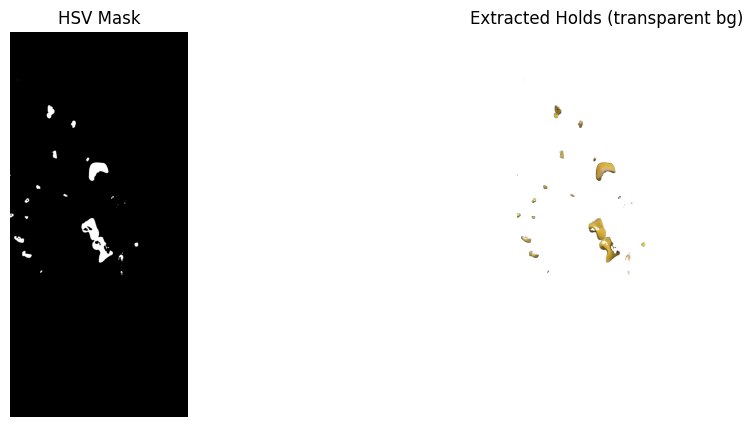

In [83]:
# Extract holds by HSV bounds and save transparent PNG (no changes to prior cells)

# Choose source RGB/HSV from existing variables
src_rgb = proc_rgb if 'proc_rgb' in globals() and proc_rgb is not None else (img_rgb if 'img_rgb' in globals() else None)
src_hsv = proc_hsv if 'proc_hsv' in globals() and proc_hsv is not None else (cv2.cvtColor(src_rgb, cv2.COLOR_RGB2HSV) if src_rgb is not None else None)

if src_rgb is None or src_hsv is None:
    print("No image available. Ensure earlier cells loaded and preprocessed the image.")
else:
    # Mask from provided HSV bounds
    mask_hsv = cv2.inRange(src_hsv, lower_hsv, upper_hsv)

    # Optional light cleanup (does not modify prior cells)
    k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask_clean = cv2.morphologyEx(mask_hsv, cv2.MORPH_OPEN, k_open, iterations=1)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, k_close, iterations=1)

    # Build RGBA with blank background
    h, w = mask_clean.shape
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    rgba[..., :3] = src_rgb
    rgba[..., 3] = (mask_clean > 0).astype(np.uint8) * 255

    # Save to exports
    export_dir = os.path.join(DATA_PATH if 'DATA_PATH' in globals() else os.path.dirname(IMG_PATH), 'exports')
    os.makedirs(export_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(IMG_PATH if 'IMG_PATH' in globals() else 'image'))[0]
    out_path = os.path.join(export_dir, f"{base}_holds_hsv.png")
    cv2.imwrite(out_path, cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA))
    print("Saved transparent PNG:", out_path)

    # Quick view
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].imshow(mask_clean, cmap='gray'); axs[0].set_title('HSV Mask'); axs[0].axis('off')
    axs[1].imshow(rgba); axs[1].set_title('Extracted Holds (transparent bg)'); axs[1].axis('off')
    plt.show()

In [79]:
# Phase 1: Enhanced Preprocessing UI + KMeans Clustering + Eyedropper + One-Click Workflow

# First, let's add a preprocessing UI cell that integrates all preprocessing options
if WIDGETS_OK and img_rgb is not None:
    from ipywidgets import Label
    
    # Preprocessing controls
    cb_grayworld = Checkbox(description='Grayworld WB', value=False)
    cb_bilateral = Checkbox(description='Bilateral Filter', value=False)
    cb_clahe = Checkbox(description='CLAHE on V', value=True)
    
    slider_bi_d = IntSlider(description='Bilateral d', min=5, max=15, value=9, step=2)
    slider_bi_sc = FloatSlider(description='σ_color', min=20, max=150, value=75.0, step=5)
    slider_bi_ss = FloatSlider(description='σ_space', min=20, max=150, value=75.0, step=5)
    slider_clahe_clip = FloatSlider(description='CLAHE clip', min=1.0, max=5.0, value=2.0, step=0.5)
    
    btn_preprocess = Button(description='Apply Preprocessing', button_style='primary')
    out_preproc = Output()
    
    def apply_preprocessing(*args):
        global proc_rgb, proc_hsv
        proc_rgb, proc_hsv = preprocess_pipeline(
            img_rgb,
            use_grayworld=cb_grayworld.value,
            use_bilateral=cb_bilateral.value,
            use_clahe=cb_clahe.value,
            bilateral_d=slider_bi_d.value,
            bilateral_sigma_color=slider_bi_sc.value,
            bilateral_sigma_space=slider_bi_ss.value,
            clahe_clip=slider_clahe_clip.value,
            scale=1.0
        )
        with out_preproc:
            out_preproc.clear_output(wait=True)
            if proc_rgb is not None:
                fig, axs = plt.subplots(1, 2, figsize=(12,5))
                axs[0].imshow(img_rgb)
                axs[0].set_title('Original')
                axs[0].axis('off')
                axs[1].imshow(proc_rgb)
                axs[1].set_title('Preprocessed')
                axs[1].axis('off')
                plt.show()
                print("Preprocessing applied. proc_rgb and proc_hsv updated.")
            else:
                print("Preprocessing failed.")
    
    btn_preprocess.on_click(apply_preprocessing)
    
    display(VBox([
        Label('Preprocessing Options'),
        HBox([cb_grayworld, cb_bilateral, cb_clahe]),
        HBox([slider_bi_d, slider_bi_sc, slider_bi_ss, slider_clahe_clip]),
        btn_preprocess,
        out_preproc
    ]))
    
    # Apply default preprocessing on load
    apply_preprocessing()
else:
    # Fallback: apply default preprocessing
    if img_rgb is not None:
        proc_rgb, proc_hsv = preprocess_pipeline(img_rgb, use_clahe=True, scale=1.0)



In [84]:
# KMeans Color Clustering in HSV (OpenCV)

def run_kmeans_clustering(img_hsv: np.ndarray, k: int = 6, max_width: int = 640) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Cluster colors using OpenCV kmeans in HSV space.
    Returns: labels, centers (HSV), pixel counts per cluster
    """
    if img_hsv is None:
        return None, None, None
    
    # Downsample for speed if needed
    h, w = img_hsv.shape[:2]
    if w > max_width:
        scale = max_width / w
        new_h, new_w = int(h * scale), int(w * scale)
        img_small = cv2.resize(img_hsv, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        img_small = img_hsv
    
    # Prepare data: Nx3 float32
    data = img_small.reshape((-1, 3)).astype(np.float32)
    
    # KMeans criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    # Count pixels per cluster
    unique, counts = np.unique(labels, return_counts=True)
    pixel_counts = np.zeros(k, dtype=int)
    for u, c in zip(unique, counts):
        pixel_counts[u] = c
    
    return labels.reshape(img_small.shape[:2]), centers.astype(np.uint8), pixel_counts

# State for selected cluster
selected_cluster_idx = None
selected_cluster_center_hsv = None

if WIDGETS_OK and proc_hsv is not None:
    slider_k = IntSlider(description='K clusters', min=5, max=8, value=6)
    btn_cluster = Button(description='Run Clustering', button_style='info')
    out_cluster = Output()
    cluster_centers_hsv = None
    cluster_labels = None
    cluster_counts = None
    
    def run_clustering(*args):
        global cluster_labels, cluster_centers_hsv, cluster_counts
        k = slider_k.value
        cluster_labels, cluster_centers_hsv, cluster_counts = run_kmeans_clustering(proc_hsv, k=k, max_width=640)
        if cluster_centers_hsv is not None:
            with out_cluster:
                out_cluster.clear_output(wait=True)
                # Display cluster swatches
                fig, axs = plt.subplots(1, k, figsize=(k*2, 2))
                if k == 1:
                    axs = [axs]
                total_pixels = cluster_counts.sum()
                for i in range(k):
                    center_hsv = cluster_centers_hsv[i]
                    center_rgb = cv2.cvtColor(np.uint8([[center_hsv]]), cv2.COLOR_HSV2RGB)[0][0]
                    pct = (cluster_counts[i] / total_pixels) * 100
                    axs[i].imshow([[center_rgb / 255.0]])
                    axs[i].set_title(f'C{i}\n{pct:.1f}%')
                    axs[i].axis('off')
                plt.tight_layout()
                plt.show()
                print(f"Clustered into {k} colors. Click 'Use' buttons below to select a cluster.")
        else:
            with out_cluster:
                print("Clustering failed.")
    
    btn_cluster.on_click(run_clustering)
    
    # Cluster selection UI
    cluster_buttons_box = VBox([])
    
    def create_cluster_buttons():
        if cluster_centers_hsv is None:
            return
        buttons = []
        for i in range(len(cluster_centers_hsv)):
            center_hsv = cluster_centers_hsv[i]
            center_rgb = cv2.cvtColor(np.uint8([[center_hsv]]), cv2.COLOR_HSV2RGB)[0][0]
            btn = Button(description=f'Use Cluster {i} (H:{center_hsv[0]}, S:{center_hsv[1]}, V:{center_hsv[2]})',
                        button_style='success')
            def make_handler(idx):
                def handler(*args):
                    global selected_cluster_idx, selected_cluster_center_hsv
                    selected_cluster_idx = idx
                    selected_cluster_center_hsv = cluster_centers_hsv[idx]
                    with out_cluster:
                        print(f"Selected cluster {idx}: HSV={selected_cluster_center_hsv.tolist()}")
                return handler
            btn.on_click(make_handler(i))
            buttons.append(btn)
        cluster_buttons_box.children = buttons
    
    def on_cluster_complete(*args):
        run_clustering()
        create_cluster_buttons()
    
    btn_cluster.on_click(on_cluster_complete)
    
    display(VBox([
        Label('KMeans Color Clustering'),
        HBox([slider_k, btn_cluster]),
        out_cluster,
        cluster_buttons_box
    ]))
else:
    print("Widgets unavailable or no HSV image. Cannot run clustering UI.")



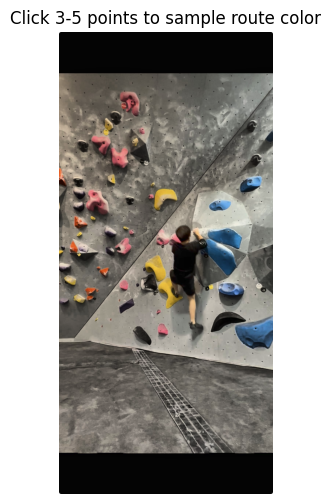

In [85]:
# Enhanced Eyedropper: Click 3-5 points, auto-compute HSV range

eyedropper_samples_hsv = []  # List of (h, s, v) tuples
selected_eyedropper_range = None  # (lower, upper) HSV arrays

def compute_hsv_range_from_samples(samples: List[Tuple[int,int,int]], tolerance_mult: float = 1.5) -> Tuple[np.ndarray, np.ndarray]:
    """Compute HSV bounds from samples using robust spread (MAD)."""
    if len(samples) < 2:
        return None, None
    arr = np.array(samples, dtype=np.float32)
    median = np.median(arr, axis=0)
    # Robust spread using median absolute deviation
    mad = np.median(np.abs(arr - median), axis=0)
    spread = mad * tolerance_mult
    lower = np.clip(median - spread, [0, 0, 0], [179, 255, 255]).astype(np.uint8)
    upper = np.clip(median + spread, [0, 0, 0], [179, 255, 255]).astype(np.uint8)
    return lower, upper

if WIDGETS_OK and proc_rgb is not None and proc_hsv is not None:
    # Interactive image for clicking samples
    fig_eye, ax_eye = plt.subplots(1, 1, figsize=(8,6))
    ax_eye.imshow(proc_rgb)
    ax_eye.set_title("Click 3-5 points to sample route color")
    ax_eye.axis('off')
    
    def on_click_eyedropper(event):
        if event.xdata is None or event.ydata is None:
            return
        x, y = int(event.xdata), int(event.ydata)
        h, s, v = proc_hsv[y, x].tolist()
        eyedropper_samples_hsv.append((int(h), int(s), int(v)))
        print(f"Sample {len(eyedropper_samples_hsv)}: HSV=({h},{s},{v}) at ({x},{y})")
        if len(eyedropper_samples_hsv) >= 3:
            lower, upper = compute_hsv_range_from_samples(eyedropper_samples_hsv, tolerance_mult=slider_tol.value)
            if lower is not None:
                global selected_eyedropper_range
                selected_eyedropper_range = (lower, upper)
                print(f"Auto-computed range: lower={lower.tolist()}, upper={upper.tolist()}")
    
    cid_eye = fig_eye.canvas.mpl_connect('button_press_event', on_click_eyedropper)
    plt.show()
    
    slider_tol = FloatSlider(description='Tolerance', min=0.5, max=3.0, value=1.5, step=0.1)
    btn_recompute_range = Button(description='Recompute Range', button_style='info')
    btn_clear_samples = Button(description='Clear Samples', button_style='warning')
    btn_use_eyedropper = Button(description='Use Eyedropper Range', button_style='success')
    out_eye = Output()
    
    def recompute_range(*args):
        if len(eyedropper_samples_hsv) >= 2:
            lower, upper = compute_hsv_range_from_samples(eyedropper_samples_hsv, tolerance_mult=slider_tol.value)
            if lower is not None:
                global selected_eyedropper_range
                selected_eyedropper_range = (lower, upper)
                with out_eye:
                    out_eye.clear_output(wait=True)
                    print(f"Range recomputed: lower={lower.tolist()}, upper={upper.tolist()}")
                    # Preview mask
                    mask_preview = cv2.inRange(proc_hsv, lower, upper)
                    fig, axs = plt.subplots(1, 2, figsize=(12,5))
                    axs[0].imshow(proc_rgb)
                    axs[0].set_title('Original')
                    axs[0].axis('off')
                    axs[1].imshow(mask_preview, cmap='gray')
                    axs[1].set_title(f'Preview Mask (samples={len(eyedropper_samples_hsv)})')
                    axs[1].axis('off')
                    plt.show()
        else:
            with out_eye:
                print("Need at least 2 samples to compute range.")
    
    def clear_samples(*args):
        eyedropper_samples_hsv.clear()
        global selected_eyedropper_range
        selected_eyedropper_range = None
        with out_eye:
            out_eye.clear_output(wait=True)
            print("Samples cleared.")
    
    btn_recompute_range.on_click(recompute_range)
    btn_clear_samples.on_click(clear_samples)
    slider_tol.observe(lambda x: recompute_range(), names='value')
    
    display(VBox([
        Label('Eyedropper Tool'),
        HBox([slider_tol, btn_recompute_range, btn_clear_samples, btn_use_eyedropper]),
        out_eye
    ]))
else:
    print("Widgets unavailable or no image. Cannot use eyedropper.")



In [ ]:
# One-Click Generate Mask Workflow: Morphology + Components + Visualization + Export

def generate_mask_with_morphology(img_hsv: np.ndarray, lower: np.ndarray, upper: np.ndarray,
                                   morph_open_size: int = 3, morph_close_size: int = 7,
                                   use_open: bool = True, use_close: bool = True,
                                   median_blur_size: int = 0,
                                   area_min: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """Generate mask, apply morphology, filter small components."""
    raw_mask = cv2.inRange(img_hsv, lower, upper)
    
    # Optional median blur
    if median_blur_size > 0 and median_blur_size % 2 == 1:
        raw_mask = cv2.medianBlur(raw_mask, median_blur_size)
    
    # Morphology
    mask = raw_mask
    if use_open:
        k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_open_size, morph_open_size))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k_open, iterations=1)
    if use_close:
        k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_close_size, morph_close_size))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close, iterations=1)
    
    # Remove small components
    if area_min > 0:
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
        filtered_mask = np.zeros_like(mask)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= area_min:
                filtered_mask[labels == i] = 255
        mask = filtered_mask
    
    return raw_mask, mask

def detect_holds_from_mask(mask: np.ndarray) -> List[dict]:
    """Detect connected components and compute properties."""
    components = []
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 1:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        M = cv2.moments(cnt)
        if M['m00'] == 0:
            cx, cy = x + w//2, y + h//2
        else:
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
        components.append({
            'area': float(area),
            'centroid': (int(cx), int(cy)),
            'bbox': (int(x), int(y), int(w), int(h)),
            'contour': cnt
        })
    return components

# Global state for final results
final_mask = None
final_components = []
final_lower_hsv = None
final_upper_hsv = None

if WIDGETS_OK and proc_hsv is not None and proc_rgb is not None:
    # Morphology controls
    slider_open_sz = IntSlider(description='Open kernel', min=1, max=15, value=3, step=2)
    slider_close_sz = IntSlider(description='Close kernel', min=1, max=21, value=7, step=2)
    cb_open = Checkbox(description='Apply Open', value=True)
    cb_close = Checkbox(description='Apply Close', value=True)
    slider_median = IntSlider(description='Median blur', min=0, max=9, value=0, step=2)
    slider_area_min = IntSlider(description='Min area', min=0, max=1000, value=100, step=10)
    
    btn_generate = Button(description='Generate Mask', button_style='success', layout={'width': '200px'})
    btn_export_png = Button(description='Export PNG', button_style='info')
    btn_export_csv = Button(description='Export CSV', button_style='info')
    out_workflow = Output()
    
    def generate_mask_workflow(*args):
        global final_mask, final_components, final_lower_hsv, final_upper_hsv
        
        # Determine HSV range: cluster > eyedropper > manual sliders
        if selected_cluster_center_hsv is not None:
            # Use cluster with margins
            center = selected_cluster_center_hsv
            margin_h, margin_sv = 10, 40
            lower = np.clip(center - np.array([margin_h, margin_sv, margin_sv]), [0,0,0], [179,255,255]).astype(np.uint8)
            upper = np.clip(center + np.array([margin_h, margin_sv, margin_sv]), [0,0,0], [179,255,255]).astype(np.uint8)
            source = f"Cluster {selected_cluster_idx}"
        elif selected_eyedropper_range is not None:
            lower, upper = selected_eyedropper_range
            source = "Eyedropper"
        else:
            # Fallback to existing lower_hsv/upper_hsv if available
            if 'lower_hsv' in globals() and 'upper_hsv' in globals():
                lower, upper = lower_hsv, upper_hsv
                source = "Manual HSV"
            else:
                with out_workflow:
                    print("No color selection available. Please select a cluster or use eyedropper.")
                return
        
        final_lower_hsv = lower
        final_upper_hsv = upper
        
        # Generate mask with morphology
        raw_mask, final_mask = generate_mask_with_morphology(
            proc_hsv, lower, upper,
            morph_open_size=slider_open_sz.value,
            morph_close_size=slider_close_sz.value,
            use_open=cb_open.value,
            use_close=cb_close.value,
            median_blur_size=slider_median.value,
            area_min=slider_area_min.value
        )
        
        # Detect holds
        final_components = detect_holds_from_mask(final_mask)
        
        # Visualize
        with out_workflow:
            out_workflow.clear_output(wait=True)
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
            
            # Original
            axs[0].imshow(proc_rgb)
            axs[0].set_title('Original')
            axs[0].axis('off')
            
            # Mask
            axs[1].imshow(final_mask, cmap='gray')
            axs[1].set_title('Final Mask')
            axs[1].axis('off')
            
            # Overlay with hold positions
            overlay = proc_rgb.copy()
            colors = plt.cm.tab20(np.linspace(0, 1, len(final_components)))
            for i, comp in enumerate(final_components):
                cx, cy = comp['centroid']
                color_rgb = (np.array(colors[i][:3]) * 255).astype(int)
                cv2.circle(overlay, (cx, cy), 8, tuple(color_rgb.tolist()), -1)
                cv2.circle(overlay, (cx, cy), 10, (255, 255, 255), 2)
            axs[2].imshow(overlay)
            axs[2].set_title(f'Detected Holds ({len(final_components)})')
            axs[2].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Mask generated from: {source}")
            print(f"HSV range: lower={lower.tolist()}, upper={upper.tolist()}")
            print(f"Detected {len(final_components)} holds")
            if final_components:
                total_area = sum(c['area'] for c in final_components)
                print(f"Total area: {total_area:.1f} px²")
    
    def export_transparent_png(*args):
        if final_mask is None or proc_rgb is None:
            with out_workflow:
                print("No mask available. Generate mask first.")
            return
        h, w = final_mask.shape
        rgba = np.zeros((h, w, 4), dtype=np.uint8)
        rgba[..., :3] = proc_rgb
        rgba[..., 3] = (final_mask > 0).astype(np.uint8) * 255
        
        export_dir = os.path.join(DATA_PATH, 'exports')
        os.makedirs(export_dir, exist_ok=True)
        base = os.path.splitext(os.path.basename(IMG_PATH))[0]
        out_path = os.path.join(export_dir, f"{base}_holds_phase1.png")
        cv2.imwrite(out_path, cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA))
        with out_workflow:
            print(f"Saved transparent PNG: {out_path}")
    
    def export_csv(*args):
        if not final_components:
            with out_workflow:
                print("No components available. Generate mask first.")
            return
        export_dir = os.path.join(DATA_PATH, 'exports')
        os.makedirs(export_dir, exist_ok=True)
        base = os.path.splitext(os.path.basename(IMG_PATH))[0]
        csv_path = os.path.join(export_dir, f"{base}_components_phase1.csv")
        
        import csv
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["area", "centroid_x", "centroid_y", "x", "y", "w", "h"])
            for c in final_components:
                cx, cy = c['centroid']
                x, y, w, h = c['bbox']
                writer.writerow([c['area'], cx, cy, x, y, w, h])
        with out_workflow:
            print(f"Saved CSV: {csv_path}")
        
        # Also save HSV bounds JSON
        if final_lower_hsv is not None and final_upper_hsv is not None:
            json_path = os.path.join(export_dir, f"{base}_hsv_bounds_phase1.json")
            cfg = {
                'lower_hsv': final_lower_hsv.tolist(),
                'upper_hsv': final_upper_hsv.tolist()
            }
            with open(json_path, 'w') as f:
                json.dump(cfg, f, indent=2)
            print(f"Saved HSV bounds: {json_path}")
    
    btn_generate.on_click(generate_mask_workflow)
    btn_export_png.on_click(export_transparent_png)
    btn_export_csv.on_click(export_csv)
    
    display(VBox([
        Label('One-Click Mask Generation'),
        HBox([cb_open, slider_open_sz, cb_close, slider_close_sz, slider_median, slider_area_min]),
        HBox([btn_generate, btn_export_png, btn_export_csv]),
        out_workflow
    ]))
else:
    print("Widgets unavailable or no image. Cannot run workflow.")

